<a href="https://colab.research.google.com/github/mpgl/dendrify-paper/blob/main/Fig7-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 7 of the manuscript. In this example our main goal is to illustrate that:*
>
> - *The simplified CA1 model we presented, can reproduce complex pathway interaction rules that rely on dendritic VGICs, in addition to essential electrophysiological properties of real neurons (Fig. 6).*
>
>
> **Important:** *since Figure 7 requires in total 242 different simulations, it is impractical and time-concuming to perform all of them in the current notebook. Therefore, to recreate panels d-f we will utilise existing data that will be downloaded from an online repository.*
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/mpgl/dendrify-paper)

## Setup

In [1]:
#@title Install dependencies and download data (might take a few seconds)
import os
if 'dendrify' in os.getcwd():
    pass
else:
    !git clone https://github.com/mpgl/dendrify-paper.git --quiet
    os.chdir('dendrify-paper')

!pip install brian2 --quiet
!git lfs pull --include=other/fig7-data.zip

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
Git LFS: (1 of 1 files) 60.96 MB / 60.96 MB


In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt, msiemens) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel
from zipfile import ZipFile
import pickle as p
import seaborn as sns
import matplotlib.patches as mpatches

b.prefs.codegen.target = 'numpy' # Improves performance significantly here
b.start_scope()    # allows running separate simulations in the same notebook

# @title Figure settings
graphite = "#4B4E53"
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
dsblue = '#0BA8E6'
light_gray = "#b5b5b5"
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'grid.linestyle': ":",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

b.rcParams.update(params)

In [3]:
# @title Analyze data from 242 simulations
# unzip data
with ZipFile("other/fig7-data.zip", mode="r") as archive:
    archive.extractall("other/pickles")

# load and curate data
path = "other/pickles/fig7-data"
ec_freqs = b.arange(0.5, 1.6, 0.1)*82
ca3_freqs = b.arange(0.5, 1.6, 0.1)*120
N_pyr = 10000

M1 = b.zeros((11, 11))
M2 = b.zeros((11, 11))
for ix, x in enumerate(ec_freqs):
    for iy, y in enumerate(ca3_freqs):
        file1 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=True FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
        file2 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=False FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
        with open(f"{path}/{file1}", 'rb') as f1, open(f"{path}/{file2}", 'rb') as f2:
            data1, data2 = p.load(f1), p.load(f2)

        spiketimes1 = data1['spiketimes']
        len_spikes1 = b.array([len(spiketimes1[neuron]) for neuron in spiketimes1])
        freqs1 = len_spikes1/(500*ms)
        mean_freq1 = b.mean(freqs1)
        M1[ix][iy] = mean_freq1

        spiketimes2 = data2['spiketimes']
        len_spikes2 = b.array([len(spiketimes2[neuron]) for neuron in spiketimes2])
        freqs2 = len_spikes2/(500*ms)
        mean_freq2 = b.mean(freqs2)
        M2[ix][iy] = mean_freq2

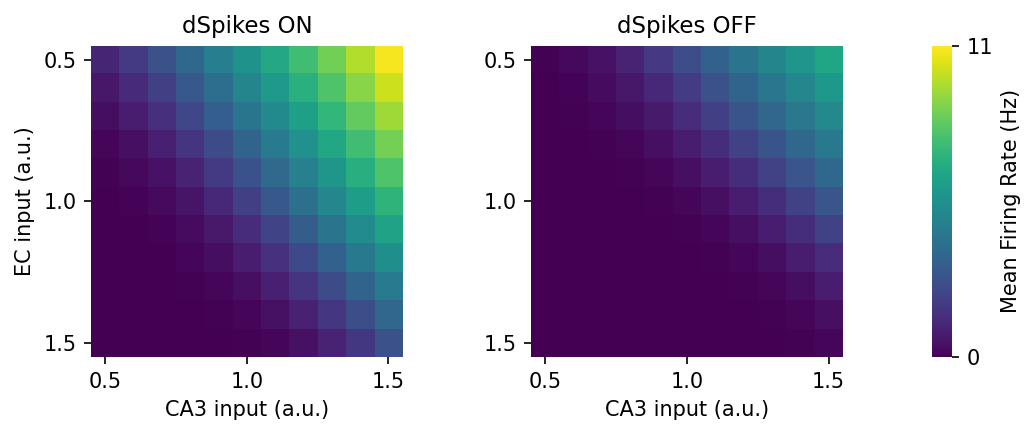

In [4]:
# @title Plot mean network firing rates
ticks = [0, 5, 10] 
tick_labels = ["0.5", "1.0", "1.5"]

fig, axes = b.subplots(ncols=3,figsize=(7.2,3),
                       gridspec_kw={"width_ratios":[1,1, 0.05]})
ax0, ax1, ax2 = axes
h1 = ax0.imshow(b.flipud(M1), vmin=0, vmax=11)
h2 = ax1.imshow(b.flipud(M2), vmin=0, vmax=11)
cb = fig.colorbar(h1, cax=ax2, ticks=[0,11], label='Mean Firing Rate (Hz)')

for ax in ax0, ax1:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


ax0.set_title("dSpikes ON")
ax0.set_ylabel("EC input (a.u.)")
ax0.set_xlabel("CA3 input (a.u.)")
ax1.set_title("dSpikes OFF")
ax1.set_xlabel("CA3 input (a.u.)")
cb.outline.set_visible(False)

fig.tight_layout()

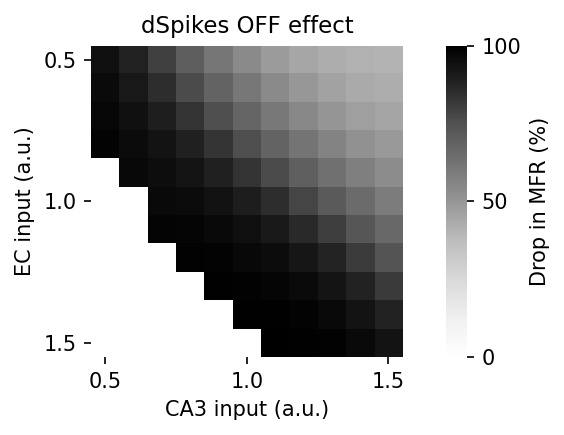

In [5]:
# @title Plot dSpikes OFF effect
M1clean = b.where(M1 > 0.1, M1, -1)
M2clean = b.where(M1 > 0.1, M2, -1)
Mdclean = (M1clean-M2clean) / M1clean

ticks = [0, 5, 10] 
tick_labels = ["0.5", "1.0", "1.5"]

fig, axes = b.subplots(ncols=2,figsize=(4,3),gridspec_kw={
                       "width_ratios":[1,0.05]})
ax0, ax1, = axes

h = ax0.imshow(b.flipud(Mdclean)*100, vmin=0, vmax=100, cmap='Greys')
cb = fig.colorbar(h, cax=ax1, ticks=[0, 50, 100], label="Drop in MFR (%)")

ax0.set_xticks(ticks)
ax0.set_yticks(ticks)
ax0.set_xticklabels(tick_labels)
ax0.set_yticklabels(tick_labels)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.set_ylabel("EC input (a.u.)")
ax0.set_xlabel("CA3 input (a.u.)")
ax0.set_title("dSpikes OFF effect")

cb.outline.set_visible(False)
fig.tight_layout()

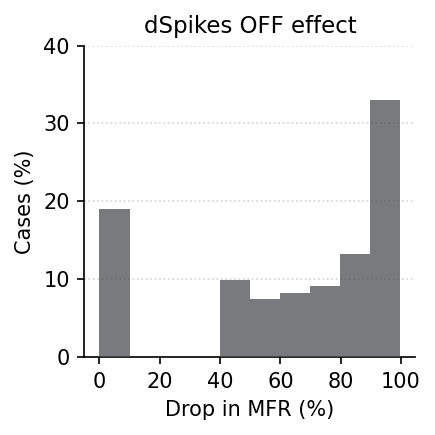

In [6]:
# @title Plot distribution 


fig, ax = b.subplots(figsize=(3,3))
ax.hist(Mdclean.flatten()*100, bins=10, color="#4B4E53",
         zorder=3, alpha=.75, antialiased=True, rasterized=True)

ytickpos = b.arange(0, 50, 10)
ax.set_yticks(b.array(ytickpos*1.21))
ax.set_yticklabels(ytickpos)
ax.set_xlabel("Drop in MFR (%)")
ax.set_ylabel("Cases (%)")
ax.set_xticks(range(0, 120, 20))
ax.yaxis.grid(zorder=0)
ax.set_title("dSpikes OFF effect")



fig.tight_layout()


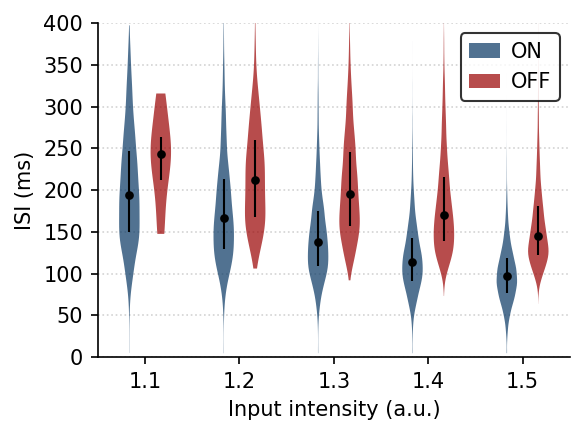

In [7]:
# @title Violin plots
import warnings
warnings.filterwarnings("ignore")

path = "other/pickles/fig7-data"
ec_freqs = b.arange(1, 1.5, 0.1)*82
ca3_freqs = b.arange(1, 1.5, 0.1)*120

data_ON = []
data_OFF = []
for x, y in zip(ec_freqs, ca3_freqs):
    file1 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=True FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
    file2 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=False FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
    with open(f"{path}/{file1}", 'rb') as f1, open(f"{path}/{file2}", 'rb') as f2:
        data1, data2 = p.load(f1), p.load(f2)

    spiketimes1 = data1['spiketimes']
    oneplus1 = [spiketimes1[neuron]
                for neuron in spiketimes1 if
                len(spiketimes1[neuron]) >= 2]
    isi1 = [(b.diff(spikes)/ms) for spikes in oneplus1]
    isi1_flat = b.hstack(isi1)
    data_ON.append(isi1_flat)

    spiketimes2 = data2['spiketimes']
    oneplus2 = [spiketimes2[neuron]
                for neuron in spiketimes2 if
                len(spiketimes2[neuron]) >= 2]
    isi2 = [(b.diff(spikes)/ms) for spikes in oneplus2]
    isi2_flat = b.hstack(isi2)
    data_OFF.append(isi2_flat)

fig, ax = b.subplots(figsize=[4,3])
violin1 = ax.violinplot(data_ON, positions=[0, 3, 6, 9, 12],
                        showextrema=False, widths=.65)
violin2 = ax.violinplot(data_OFF, positions=[1, 4, 7, 10, 13],
                        showextrema=False, widths=.65)

for vp1, vp2 in zip(violin1['bodies'],  violin2['bodies']):
    vp1.set_facecolor('#073763')
    vp1.set_zorder(2)
    vp1.set_alpha(0.7)
    vp2.set_facecolor('#990000')
    vp2.set_zorder(2)
    vp2.set_alpha(0.7)

medians = []
quartile1 = []
quartile3 = []

for i in data_OFF:
    q1, median, q3 = b.percentile(i, [25, 50, 75], axis=0)
    medians.append(median)
    quartile1.append(q1)
    quartile3.append(q3)

inds = [1, 4, 7, 10, 13]
ax.scatter(inds, medians, marker='o', color='black', s=10, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=1)

medians = []
quartile1 = []
quartile3 = []

for i in data_ON:
    q1, median, q3 = b.percentile(i, [25, 50, 75], axis=0)
    medians.append(median)
    quartile1.append(q1)
    quartile3.append(q3)

inds = [0, 3, 6, 9, 12]
ax.scatter(inds, medians, marker='o', color='black', s=10, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=1)

handles = [mpatches.Patch(edgecolor=None, facecolor='#073763', alpha=.7),
           mpatches.Patch(edgecolor=None, facecolor='#990000', alpha=.7)]
labels = ['ON', 'OFF']
ax.legend(handles, labels, loc='upper right', ncol=1)
ax.yaxis.grid(zorder=0)
ax.set_ylabel("ISI (ms)")
ax.set_xlabel("Input intensity (a.u.)")
ax.set_ylim(top=400, bottom=0)
ax.set_xticks(b.arange(0, 15, 3)+.5)
ax.set_xticklabels([1.1, 1.2, 1.3, 1.4, 1.5])
fig.tight_layout()